<a href="https://colab.research.google.com/github/dton24/apache_spark_project/blob/main/K_Means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Packages

In [ ]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=98532d8514b5086ecf07f3d2559ebf128b164a7da4d003d306149d10dee85f5e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
# Import necessary packages
import os
from pyspark.sql import SparkSession
import pyspark.pandas as ps

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


## Load Data

In [ ]:
# Read the CSV file directly with Pandas-on-Spark
df = ps.read_csv('Preprocessed_Google_CSV.csv', header=0)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [ ]:
df['Rating'].describe()

count    6655.000000
mean        4.214050
std         0.462055
min         2.600000
25%         4.000000
50%         4.300000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

### Clustering

**Selecting the numerical values and saving it into a new dataframe**

In [ ]:

psdf = df[['Rating', 'Reviews', 'Size', 'Installs', 'Price']]

print(psdf.head())

   Rating  Reviews  Size  Installs  Price
0     3.2     55.0   2.7      5000    0.0
1     3.4    486.0   5.9    100000    0.0
2     3.8    178.0  19.0     50000    0.0
3     3.8   2206.0   1.2    100000    0.0
4     3.8    564.0   9.2    100000    0.0


**Elbow Chart**: This tell us how many clusters we should use!

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


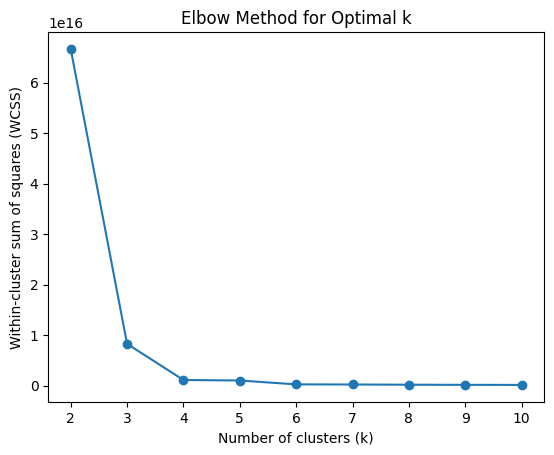

In [ ]:
import matplotlib.pyplot as plt
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import pyspark.pandas as ps

# Function to compute WCSS
def compute_wcss(data, k):
    kmeans = KMeans(k=k, seed=666, featuresCol='features')
    model = kmeans.fit(data)
    return model.summary.trainingCost


# Convert pandas-on-Spark DataFrame to Spark DataFrame
spark_df = psdf.to_spark()

# Prepare features using VectorAssembler
inputCols = ['Rating', 'Reviews', 'Size', 'Installs', 'Price']
vectorAssembler = VectorAssembler(inputCols=inputCols, outputCol='features')
pipeline = Pipeline(stages=[vectorAssembler])
spark_df = pipeline.fit(spark_df).transform(spark_df)

# Range of cluster numbers to try (start from k=2)
k_values = range(2, 11)
wcss_values = [compute_wcss(spark_df, k) for k in k_values]

# Plot the elbow chart
plt.plot(k_values, wcss_values, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster sum of squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()


**Normalize the data, create clusters using euclidean distance, add new columns to our new dataframe (features, standardized, prediction)**

In [ ]:
import pyspark.ml.clustering as clust
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
import pyspark.pandas as ps

# List of numeric columns to normalize
inputCols = ['Rating', 'Reviews', 'Size', 'Installs', 'Price']

# VectorAssembler to combine input columns
vectorAssembler = VectorAssembler(
    inputCols=inputCols,
    outputCol='features'
)

# StandardScaler for normalization
norm = StandardScaler(
    inputCol='features',
    outputCol='standardized',
    withMean=True,
    withStd=True
)

# kMeans with k = 4
kmeans_obj = clust.KMeans(
    k=4,
    seed=666,
    featuresCol='standardized',
    distanceMeasure='euclidean'
)

# Creating a pipeline
pipeline = Pipeline(stages=[vectorAssembler, norm, kmeans_obj])

# Convert pandas-on-Spark DataFrame to Spark DataFrame
spark_df = psdf.to_spark()

# Fit and transform the pipeline
clustering_results = pipeline.fit(spark_df).transform(spark_df)

# Convert Spark DataFrame back to pandas-on-Spark DataFrame
ps_clustering_results = clustering_results.to_pandas_on_spark()

ps_clustering_results

/usr/local/lib/python3.10/dist-packages/pyspark/sql/dataframe.py:5723: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


,Rating,Reviews,Size,Installs,Price,features,standardized,prediction
0,3.2,55.0,2.7,5000,0.00,"[3.2, 55.0, 2.7, 5000.0, 0.0]","[-2.194649858418569, -0.27640477864629004, -0....",0
1,3.4,486.0,5.9,100000,0.00,"[3.4, 486.0, 5.9, 100000.0, 0.0]","[-1.7618012310858138, -0.27490703696694135, -0...",0
2,3.8,178.0,19.0,50000,0.00,"[3.8, 178.0, 19.0, 50000.0, 0.0]","[-0.8961039764203019, -0.2759773488862903, -0....",0
3,3.8,2206.0,1.2,100000,0.00,"[3.8, 2206.0, 1.2, 100000.0, 0.0]","[-0.8961039764203019, -0.2689299704043434, -0....",0
4,3.8,564.0,9.2,100000,0.00,"[3.8, 564.0, 9.2, 100000.0, 0.0]","[-0.8961039764203019, -0.27463598394840494, -0...",0
5,3.9,136.0,4.6,10000,0.00,"[3.9, 136.0, 4.6, 10000.0, 0.0]","[-0.6796796627539237, -0.27612330051165607, -0...",0
6,3.9,967.0,14.0,500000,0.00,"[3.9, 967.0, 14.0, 500000.0, 0.0]","[-0.6796796627539237, -0.27323554335263345, -0...",0
7,4.0,18.0,3.6,1000,0.00,"[4.0, 18.0, 3.6, 1000.0, 0.0]","[-0.4632553490875455, -0.27653335507815985, -0...",0
8,4.0,450.0,14.0,100000,0.00,"[4.0, 450.0, 14.0, 100000.0, 0.0]","[-0.4632553490875455, -0.27503213836011203, -0...",0
9,4.0,591.0,9.4,500000,0.00,"[4.0, 591.0, 9.4, 500000.0, 0.0]","[-0.4632553490875455, -0.27454215790352693, -0...",0


**Evaluate Clustering using Silhoulette Score**

The Silhouette score ranges from -1 to 1 and measures how well data points are clustered:

- 1: Perfect clustering. Data points are very close to their own cluster and far from other clusters.
- 0: Data points are on the border between clusters, indicating overlapping clusters.
- -1: Incorrect clustering. Data points are closer to other clusters than to their own.

In [ ]:
# Evaluate clustering
from pyspark.ml.evaluation import ClusteringEvaluator
clustering_ev = ClusteringEvaluator(featuresCol='standardized')
score = clustering_ev.evaluate(clustering_results)
print(f"Silhouette Score: {score}")

Silhouette Score: 0.5340625278054737


A Silhouette score of 0.5341 is a positive indication of the clustering quality.

A Silhouette score between 0.5 and 0.7 suggests that the clusters are moderately well-defined. Data points are closer to their own clusters than to other clusters, which is a good sign of distinct groupings.








**Look at how many data points fall under each cluster**

In [ ]:
ps_clustering_results.prediction.value_counts()

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/base.py:1437: FutureWarning: The resulting Series will have a fixed name of 'count' from 4.0.0.
  warnings.warn(


0    4961
2    1493
3     146
1      55
Name: prediction, dtype: int64

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


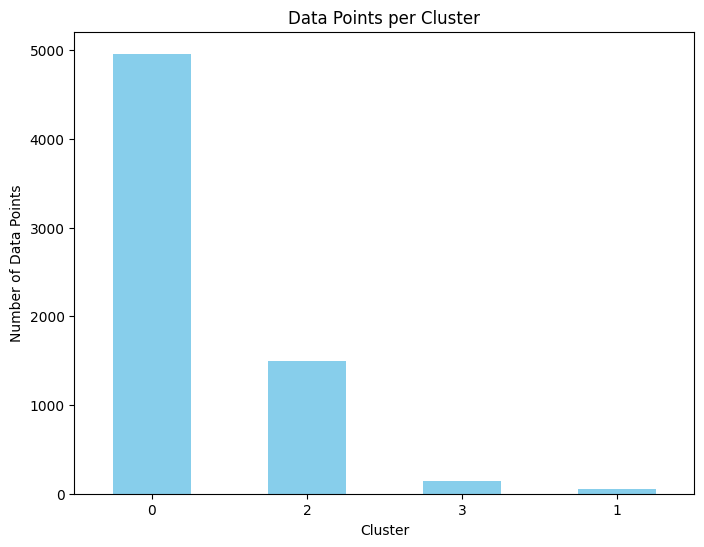

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'ps_clustering_results' is your pandas-on-Spark DataFrame
# Convert to a Pandas DataFrame
ps_clustering_results_pd = ps_clustering_results.to_pandas()

# Count the number of data points in each cluster
cluster_counts = ps_clustering_results_pd['prediction'].value_counts()

# Plot the counts as a bar chart
plt.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color='skyblue')
plt.title('Data Points per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.xticks(rotation=0)
plt.show()


Most of the data points fall under clusters 0 and 2.

**Create a Profile Plot**

A profile plot will help us see the numerical values of each feature for each cluster. This will give us a better understanding of what makes these clusters unique from each other, which will help  us label these clusters.

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


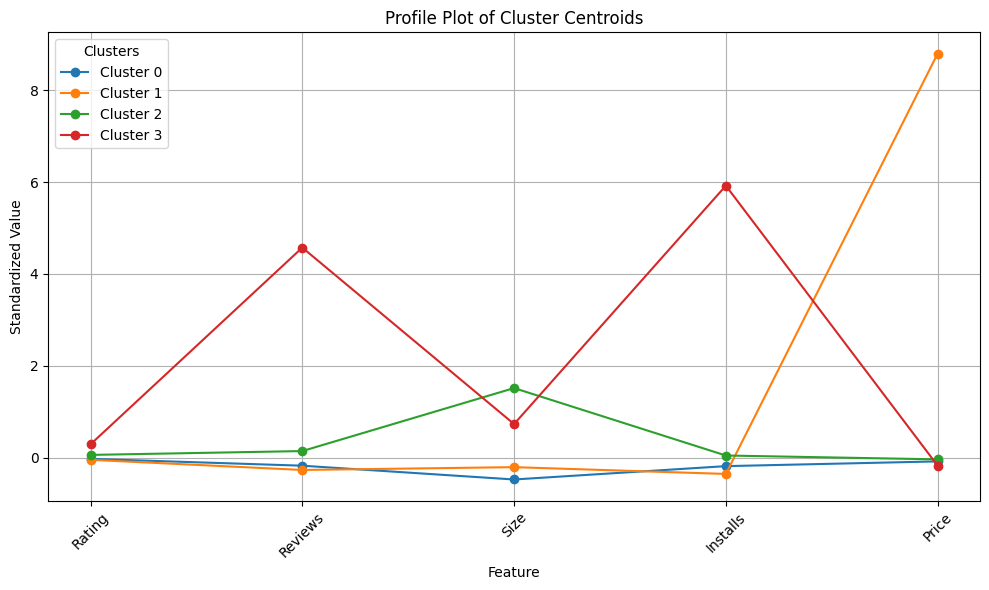

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert to a Pandas DataFrame for easier manipulation
ps_clustering_results_pd = ps_clustering_results.to_pandas()

# Extract the numeric values from the 'standardized' column and create a DataFrame
standardized_vals = pd.DataFrame(ps_clustering_results_pd['standardized'].tolist(), columns=['Rating', 'Reviews', 'Size', 'Installs', 'Price'])

# Add the 'prediction' column to this DataFrame
standardized_vals['prediction'] = ps_clustering_results_pd['prediction']

# Group by the prediction (cluster) and compute the mean for each cluster
cluster_centroids = standardized_vals.groupby('prediction').mean()

# Plot the centroids in a profile plot
fig, ax = plt.subplots(figsize=(10, 6))
for i, row in cluster_centroids.iterrows():
    ax.plot(row.index, row.values, label=f'Cluster {i}', marker='o')

ax.set_title('Profile Plot of Cluster Centroids')
ax.set_xlabel('Feature')
ax.set_ylabel('Standardized Value')
ax.legend(title='Clusters')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()



- Cluster 0 (Standard Performers): The profile suggests an even distribution of values, with nothing significantly higher or lower than others.

- Cluster 1 (Premium Priced): The distinct spike in 'Price' suggests these items are priced significantly higher than others.

- Cluster 2 (Balanced Metrics): A balanced profile, with values fluctuating moderately across features.

- Cluster 3 (High Usage and Reviews): A notable spike in 'Reviews', accompanied by elevated 'Size' and 'Installs', suggests these items are widely used and reviewed.


## Labeling Each Cluster

**I will name the new column as "Market Segment**

In [ ]:
# Mapping of cluster numbers to descriptive labels
cluster_labels = {
    0: "Standard Performers",
    1: "Premium Priced",
    2: "Balanced Metrics",
    3: "High Usage and Reviews"
}

In [ ]:
# Convert to pandas
ps_clustering_results_pd = ps_clustering_results.to_pandas()

# Add a new column named 'Market Segment' with descriptive cluster labels
ps_clustering_results_pd['Market Segment'] = ps_clustering_results_pd['prediction'].map(cluster_labels)

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


In [ ]:
ps_clustering_results_pd['Market Segment']

0       Standard Performers
1       Standard Performers
2       Standard Performers
3       Standard Performers
4       Standard Performers
               ...         
6650    Standard Performers
6651    Standard Performers
6652    Standard Performers
6653    Standard Performers
6654    Standard Performers
Name: Market Segment, Length: 6655, dtype: object

In [ ]:
# Check the result
df = df.to_pandas()
df.shape

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


(6655, 9)

In [ ]:
# Ensure 'df' is a regular Pandas DataFrame
df.reset_index(drop=True, inplace=True)

# Concatenate 'Market Segment' column to 'df'
df = pd.concat([df, ps_clustering_results_pd[['Market Segment']]], axis=1)

# Check the result
print(df.shape)
print(df.head())

(6655, 10)
         Category  Rating  Reviews  Size  Installs  Type  Price  \
0  ART_AND_DESIGN     3.2     55.0   2.7      5000  Free    0.0   
1  ART_AND_DESIGN     3.4    486.0   5.9    100000  Free    0.0   
2  ART_AND_DESIGN     3.8    178.0  19.0     50000  Free    0.0   
3  ART_AND_DESIGN     3.8   2206.0   1.2    100000  Free    0.0   
4  ART_AND_DESIGN     3.8    564.0   9.2    100000  Free    0.0   

  Content Rating   Android Ver       Market Segment  
0       Everyone    4.2 and up  Standard Performers  
1       Everyone    5.0 and up  Standard Performers  
2       Everyone  4.0.3 and up  Standard Performers  
3       Everyone    4.1 and up  Standard Performers  
4       Everyone    4.1 and up  Standard Performers  


In [ ]:
# Save 'df' as a CSV file
# df.to_csv('dataset_with_clusters.csv', index=False)

# To download the file in Google Colab, use the following:
 #from google.colab import files
# files.download('dataset_with_clusters.csv')

# Scatter Plots

**Rating and Review**

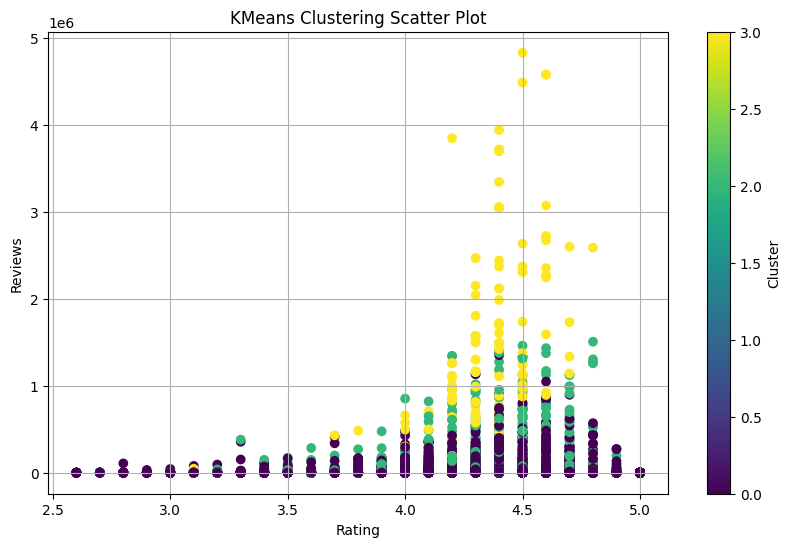

In [ ]:
import matplotlib.pyplot as plt

# Convert to a Pandas DataFrame for easier manipulation
ps_clustering_results_pd = ps_clustering_results.to_pandas()

# Choose the two features you want to visualize
# For example, 'Rating' and 'Reviews'
x_feature = 'Rating'
y_feature = 'Reviews'

# Extract values for plotting
x = ps_clustering_results_pd[x_feature]
y = ps_clustering_results_pd[y_feature]
predictions = ps_clustering_results_pd['prediction']

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=predictions, cmap='viridis', marker='o')
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title('KMeans Clustering Scatter Plot')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

- Cluster 0 (Purple):
Concentrated in the lower left area of the plot.
Mostly consists of apps with lower Rating (between 2.5 and 4.0) and lower Reviews.
- Cluster 1 (Yellow):
Spread across a wide range of Rating, but mainly above 4.0.
Concentrated in apps with very high Reviews.
- Cluster 2 (Green):
Covers a moderate range of Rating and Reviews.
Found mainly in the middle region for both Rating and Reviews.
- Cluster 3 (Light Blue):
Focused mainly in the Rating range of 3.5 to 5.0.
Includes apps with a wide range of Reviews, but generally fewer than in Cluster 1.

**Rating and Size**

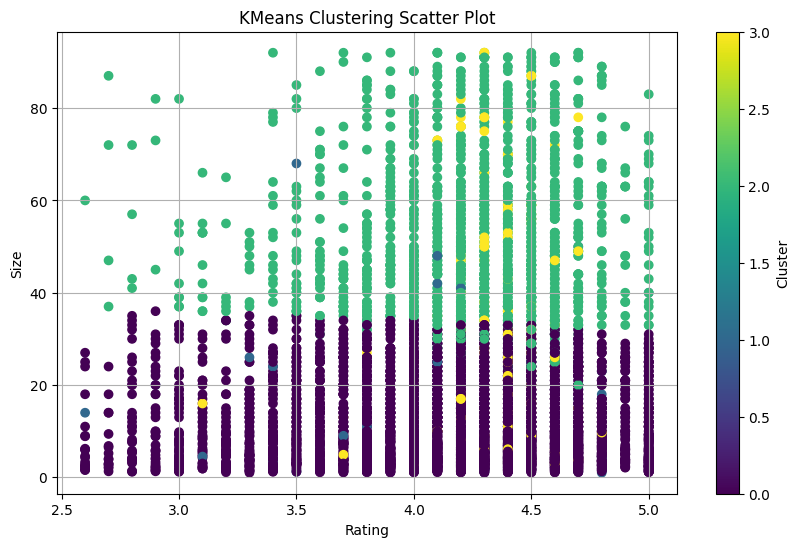

In [ ]:
import matplotlib.pyplot as plt

# Convert to a Pandas DataFrame for easier manipulation
ps_clustering_results_pd = ps_clustering_results.to_pandas()

# Choose the two features you want to visualize
# For example, 'Rating' and 'Reviews'
x_feature = 'Rating'
y_feature = 'Size'

# Extract values for plotting
x = ps_clustering_results_pd[x_feature]
y = ps_clustering_results_pd[y_feature]
predictions = ps_clustering_results_pd['prediction']

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=predictions, cmap='viridis', marker='o')
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title('KMeans Clustering Scatter Plot')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


- Cluster Differences: The plot highlights differences in Size and Rating between clusters.
- Cluster 0: Apps with smaller Size and lower Rating are grouped together.
- Cluster 1 and others: Have a broader distribution of Size and Rating.

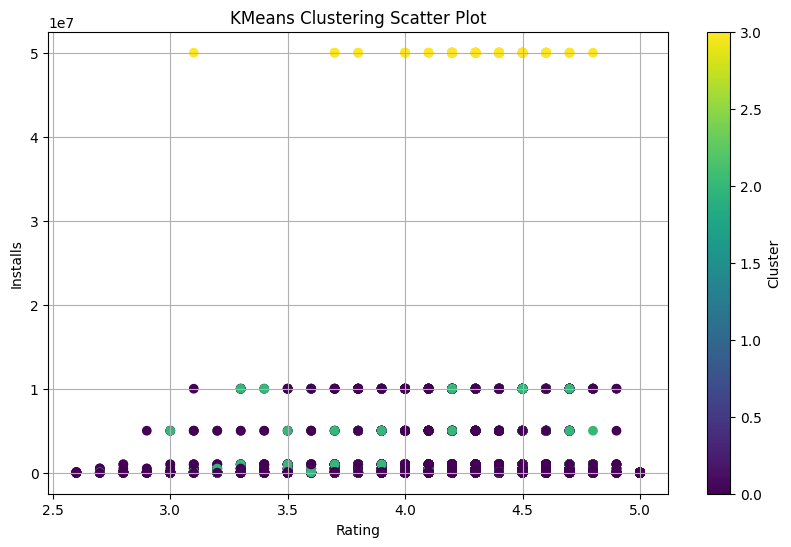

In [ ]:
import matplotlib.pyplot as plt

# Convert to a Pandas DataFrame for easier manipulation
ps_clustering_results_pd = ps_clustering_results.to_pandas()

# Choose the two features you want to visualize
# For example, 'Rating' and 'Reviews'
x_feature = 'Rating'
y_feature = 'Installs'

# Extract values for plotting
x = ps_clustering_results_pd[x_feature]
y = ps_clustering_results_pd[y_feature]
predictions = ps_clustering_results_pd['prediction']

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=predictions, cmap='viridis', marker='o')
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title('KMeans Clustering Scatter Plot')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


- The yellow cluster (labeled as cluster 3) shows a distinct group with a 'Rating' near 5.0.
- Other clusters, colored in purple and green, show more diversity and seem to cluster around lower 'Ratings' and 'Installs.'

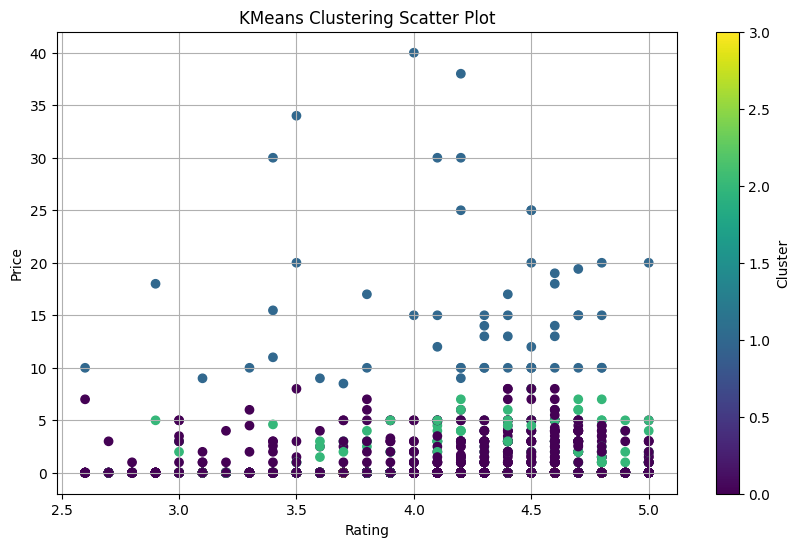

In [ ]:
import matplotlib.pyplot as plt

# Convert to a Pandas DataFrame for easier manipulation
ps_clustering_results_pd = ps_clustering_results.to_pandas()

# Choose the two features you want to visualize
# For example, 'Rating' and 'Reviews'
x_feature = 'Rating'
y_feature = 'Price'

# Extract values for plotting
x = ps_clustering_results_pd[x_feature]
y = ps_clustering_results_pd[y_feature]
predictions = ps_clustering_results_pd['prediction']

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=predictions, cmap='viridis', marker='o')
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title('KMeans Clustering Scatter Plot')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


- Cluster 0 (Purple):
Contains the majority of data points.
Mostly represents low 'Price' data points, many with 'Price' at 0.
Ratings range from 2.5 to 5.0.
- Cluster 1 (Teal/Green):
Represents a moderate number of data points.
'Price' distribution is relatively low, typically below 5.
Ratings range from 3.0 to 5.0.
- Cluster 2 (Blue):
Represents data points with 'Price' mostly ranging between 5 to 40.
The 'Rating' values are generally between 3.0 to 5.0.
- Cluster 3 (Yellow):
Sparse data points and may contain outliers.
Higher 'Rating' values are visible.

**Reviews and Size**

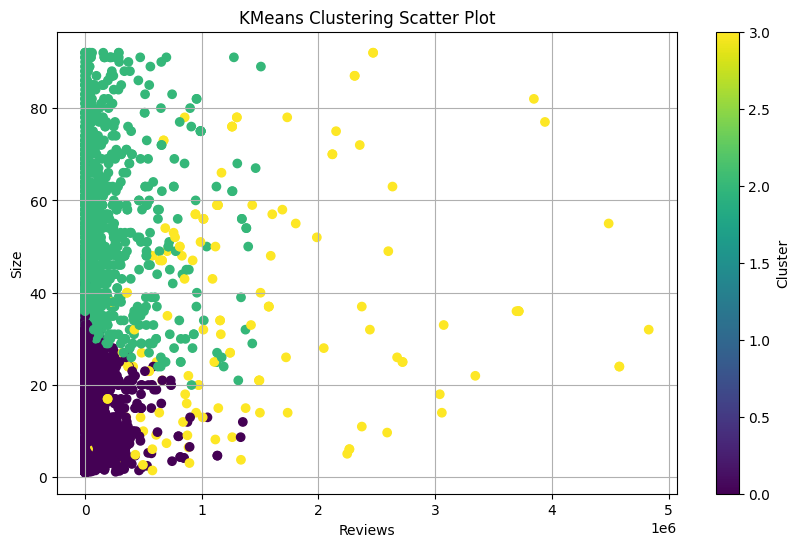

In [ ]:
import matplotlib.pyplot as plt

# Convert to a Pandas DataFrame for easier manipulation
ps_clustering_results_pd = ps_clustering_results.to_pandas()

# Choose the two features you want to visualize
# For example, 'Rating' and 'Reviews'
x_feature = 'Reviews'
y_feature = 'Size'

# Extract values for plotting
x = ps_clustering_results_pd[x_feature]
y = ps_clustering_results_pd[y_feature]
predictions = ps_clustering_results_pd['prediction']

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=predictions, cmap='viridis', marker='o')
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title('KMeans Clustering Scatter Plot')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


- Cluster 0 contains items with generally low 'Reviews' and smaller 'Size', suggesting it might include smaller or less popular items.
- Cluster 1 shows a wider distribution in 'Size', indicating a mixture of medium-sized items with varying popularity.
- Cluster 2 highlights products that are generally larger and have more 'Reviews', implying they might be more popular or well-established products.

**Reviews and Installs**

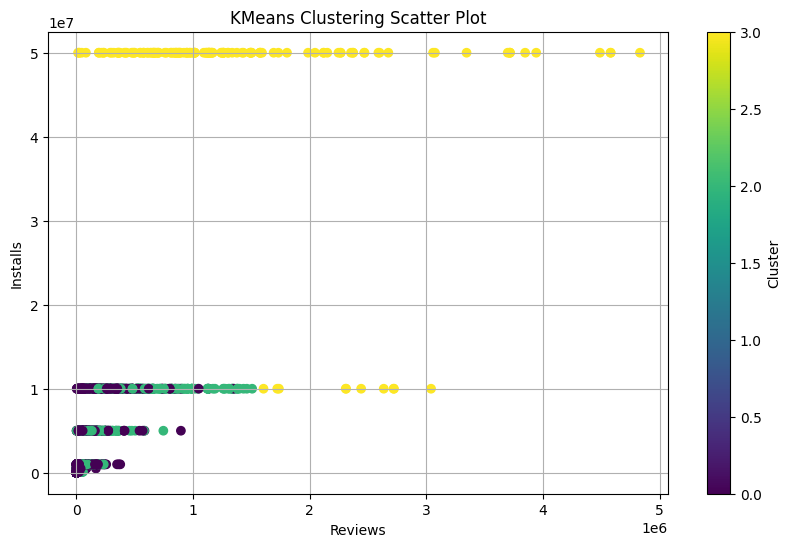

In [ ]:
import matplotlib.pyplot as plt

# Convert to a Pandas DataFrame for easier manipulation
ps_clustering_results_pd = ps_clustering_results.to_pandas()

# Choose the two features you want to visualize
# For example, 'Rating' and 'Reviews'
x_feature = 'Reviews'
y_feature = 'Installs'

# Extract values for plotting
x = ps_clustering_results_pd[x_feature]
y = ps_clustering_results_pd[y_feature]
predictions = ps_clustering_results_pd['prediction']

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=predictions, cmap='viridis', marker='o')
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title('KMeans Clustering Scatter Plot')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


- Cluster 0 (Purple):
Most data points are clustered at lower 'Reviews' values below 1 million and lower 'Installs' below 1 million.
This indicates a significant concentration of products with low popularity in both 'Reviews' and 'Installs'.
- Cluster 1 (Teal):
Shows a similar pattern to Cluster 0, but with slightly higher 'Installs', clustering primarily below 10 million.
'Reviews' count remains below 1 million for most data points.
- Cluster 2 (Yellow):
Data points extend across the whole 'Reviews' axis, reaching up to 5 million.
'Installs' values are generally higher, ranging from approximately 10 million to 50 million.
This cluster shows products with both high 'Reviews' and 'Installs', suggesting higher popularity.

**Reviews and Price**

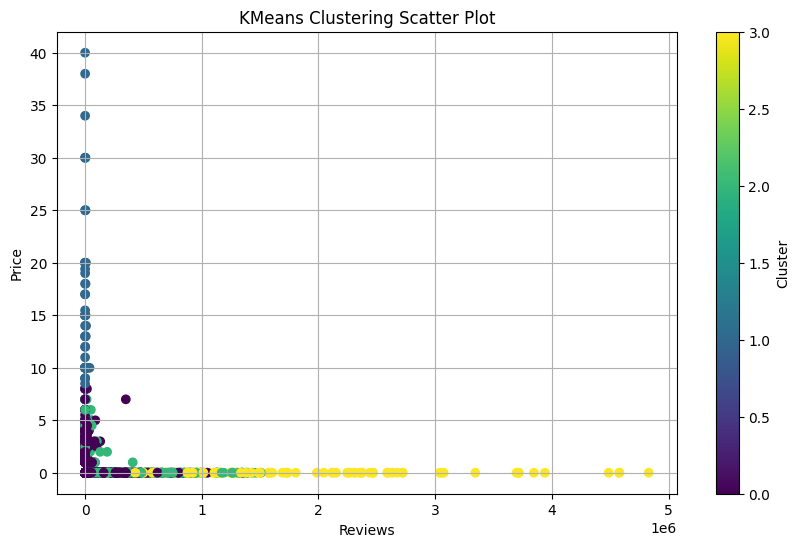

In [ ]:
import matplotlib.pyplot as plt

# Convert to a Pandas DataFrame for easier manipulation
ps_clustering_results_pd = ps_clustering_results.to_pandas()

# Choose the two features you want to visualize
# For example, 'Rating' and 'Reviews'
x_feature = 'Reviews'
y_feature = 'Price'

# Extract values for plotting
x = ps_clustering_results_pd[x_feature]
y = ps_clustering_results_pd[y_feature]
predictions = ps_clustering_results_pd['prediction']

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=predictions, cmap='viridis', marker='o')
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title('KMeans Clustering Scatter Plot')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


**Size and Installs**

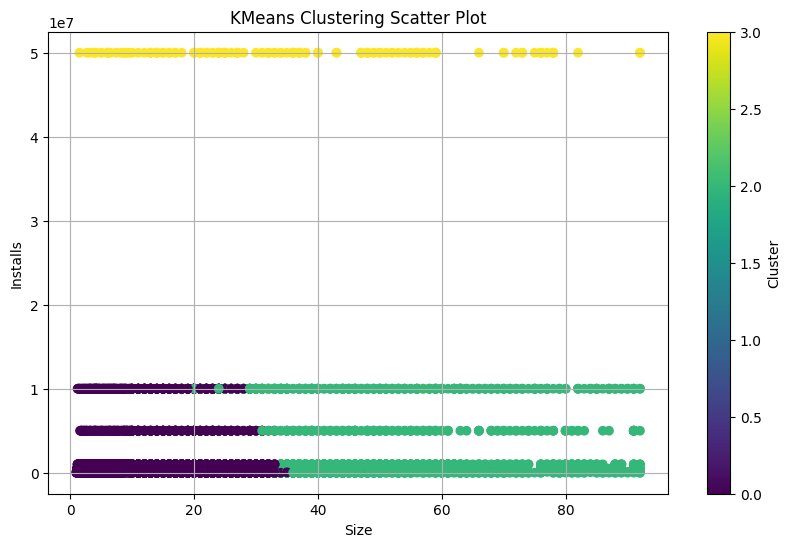

In [ ]:
import matplotlib.pyplot as plt

# Convert to a Pandas DataFrame for easier manipulation
ps_clustering_results_pd = ps_clustering_results.to_pandas()

# Choose the two features you want to visualize
# For example, 'Rating' and 'Reviews'
x_feature = 'Size'
y_feature = 'Installs'

# Extract values for plotting
x = ps_clustering_results_pd[x_feature]
y = ps_clustering_results_pd[y_feature]
predictions = ps_clustering_results_pd['prediction']

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=predictions, cmap='viridis', marker='o')
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title('KMeans Clustering Scatter Plot')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


- Clusters 0 and 1 consist of products with relatively low installs and reviews, possibly less popular or newly launched.
- Cluster 2 includes products with low 'Reviews' but a significant price range.
- Cluster 3 appears to represent products that are highly reviewed but priced similarly to products in the lower clusters.

**Size and Price**

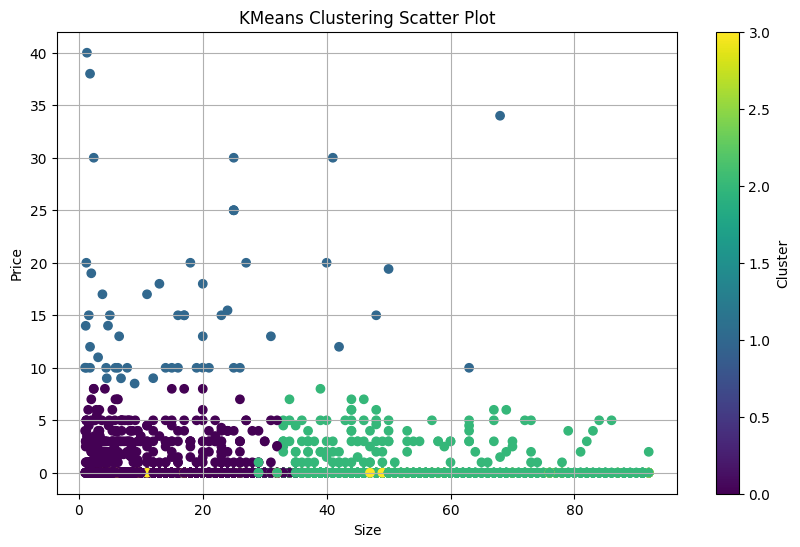

In [ ]:
import matplotlib.pyplot as plt

# Convert to a Pandas DataFrame for easier manipulation
ps_clustering_results_pd = ps_clustering_results.to_pandas()

# Choose the two features you want to visualize
# For example, 'Rating' and 'Reviews'
x_feature = 'Size'
y_feature = 'Price'

# Extract values for plotting
x = ps_clustering_results_pd[x_feature]
y = ps_clustering_results_pd[y_feature]
predictions = ps_clustering_results_pd['prediction']

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=predictions, cmap='viridis', marker='o')
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title('KMeans Clustering Scatter Plot')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


- Cluster 0 (Purple):
Contains data points with low 'Price' (typically below 5) and 'Size' (mainly below 30).
Represents items that are smaller in size and priced affordably or free.
- Cluster 1 (Teal):
Represents a broader range of 'Size' (between 10 and 100) and 'Price' (mostly below 10).
This cluster seems to represent more diverse products with varying 'Size'.
- Cluster 2 (Blue):
Contains fewer data points with a wider range of 'Price' (up to 40) and a diverse range of 'Size'.
This cluster includes more expensive items with varied sizes.
- Cluster 3 (Yellow):
Contains very few data points, often having both low 'Size' and 'Price' values.
Indicates some unique cases, possibly outliers.

**Installs and Price**

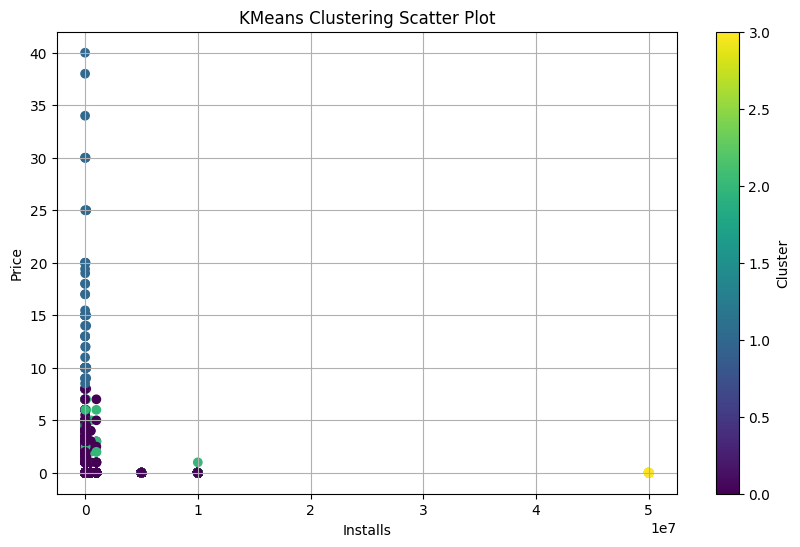

In [ ]:
import matplotlib.pyplot as plt

# Convert to a Pandas DataFrame for easier manipulation
ps_clustering_results_pd = ps_clustering_results.to_pandas()

# Choose the two features you want to visualize
# For example, 'Rating' and 'Reviews'
x_feature = 'Installs'
y_feature = 'Price'

# Extract values for plotting
x = ps_clustering_results_pd[x_feature]
y = ps_clustering_results_pd[y_feature]
predictions = ps_clustering_results_pd['prediction']

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x, y, c=predictions, cmap='viridis', marker='o')
plt.xlabel(x_feature)
plt.ylabel(y_feature)
plt.title('KMeans Clustering Scatter Plot')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()


- Clusters 0 and 1 show products with relatively low 'Installs' and low 'Price', possibly less popular or free products.
- Cluster 2 includes products with higher 'Price' but low 'Installs'.
- Cluster 3 contains a unique outlier, representing a popular product with high installs.

---